## 논의
또래지명과 자기보고의 데이터특성 차이로 적절한 비교방법 탐색이 필요함

보고방식|설명|최소|최대|
|------|---|---|---|
|또래지명|A가 다른 학생들로부터 지명받은 횟수|0|학생수|
|리커트|타인 또는 본인에게 1-5점으로 평가한 점수|1|5|

In [2]:
# 또래 지명 응답값 불러오기
import pandas as pd
import requests
from io import BytesIO
url = "https://raw.githubusercontent.com/Byumin/peer/refs/heads/item/student_point_df.csv"
point_df = pd.read_csv(url)
point_df

,point_item_no,student_designation,student_nomination
0,PN1,student1,student15
1,PN1,student2,student8
2,PN1,student3,student5
3,PN1,student4,student16
4,PN1,student5,student8
...,...,...,...
784,PN19,student19,student11
785,PN19,student19,student5
786,PN19,student19,student14
787,PN19,student20,student4


또래지명 결과 산출
* 지명수/학생수 = 비율 점수 산출

In [5]:
# 또래지명 비율 점수 산출 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 0~1 비율
def point_ratio_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
        ratio = round(len(temp_df[temp_df['student_nomination']==name])/(len(temp_df['student_designation'].unique())-1),2)
        print('지명된 횟수 :', len(temp_df[temp_df['student_nomination']==name]), '지명 가능한 수 :', (len(temp_df['student_designation'].unique())-1))
    return ratio

# 지명 횟수 산출 함수
def count_score(point_df, item, name):
  if not item:
    return 0
  else :
    item='|'.join(item)
    temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
    count = len(temp_df[temp_df['student_nomination']==name])
    return count

In [7]:
item = ['PN1']
point_ratio_score(point_df, item, 'student20')

지명된 횟수 : 2 지명 가능한 수 : 19


0.11

지명된 횟수 : 3 지명 가능한 수 : 19
지명된 횟수 : 1 지명 가능한 수 : 19
지명된 횟수 : 3 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 0 지명 가능한 수 : 19
지명된 횟수 : 4 지명 가능한 수 : 19
지명된 횟수 : 3 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 0 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 1 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 5 지명 가능한 수 : 19
지명된 횟수 : 4 지명 가능한 수 : 19
지명된 횟수 : 1 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19
지명된 횟수 : 1 지명 가능한 수 : 19
지명된 횟수 : 2 지명 가능한 수 : 19


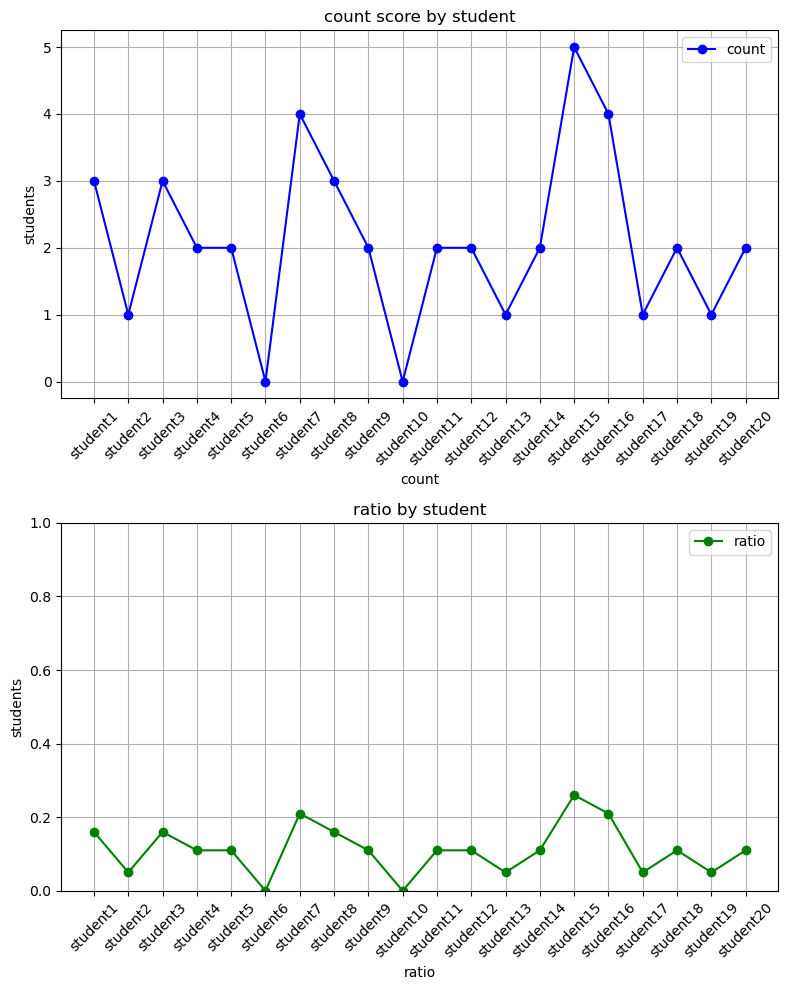

In [9]:
import matplotlib.pyplot as plt

# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN1']
ratio = [point_ratio_score(point_df, item, student) for student in students]
counts = [count_score(point_df, item, student) for student in students]

# 서브플롯 생성 (2행 1열)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))  # figsize로 크기 조정 가능

# 첫 번째 그래프
axes[0].plot(students, counts, marker='o', color='b', label="count")
axes[0].set_title("count score by student")
axes[0].set_xlabel("count")
axes[0].set_xticks(range(len(students)))
axes[0].set_xticklabels(students, rotation=45)
axes[0].set_ylabel("students")
axes[0].legend()
axes[0].grid(True)

# 두 번째 그래프
axes[1].plot(students, ratio, marker='o', color='g', label="ratio")
axes[1].set_title("ratio by student")
axes[1].set_xlabel("ratio")
axes[1].set_xticks(range(len(students)))
axes[1].set_xticklabels(students, rotation=45)
axes[1].set_ylabel("students")
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True)

# 그래프 조정 및 출력
plt.tight_layout()  # 서브플롯 간 간격 조정
plt.show()

# 상대적 위치가 아닌 절대적 위치를 확인할 수 있는 결과라서
# 그래프가 전반적으로 플랫하게 나타남

또래지명 결과 산출
* 지명수 평균과 표준편차 활용하여 Z점수 산출

In [12]:
# 또래지명 Z 점수 산출 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 평균=0, 표준편차=1 표준화
import numpy as np
from scipy.stats import zscore

def point_z_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
        z_score_list = zscore(temp_list)
        z_score = z_score_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return z_score

In [14]:
item = ['PN1']
point_z_score(point_df, item, 'student20')

-0.07930515857181447

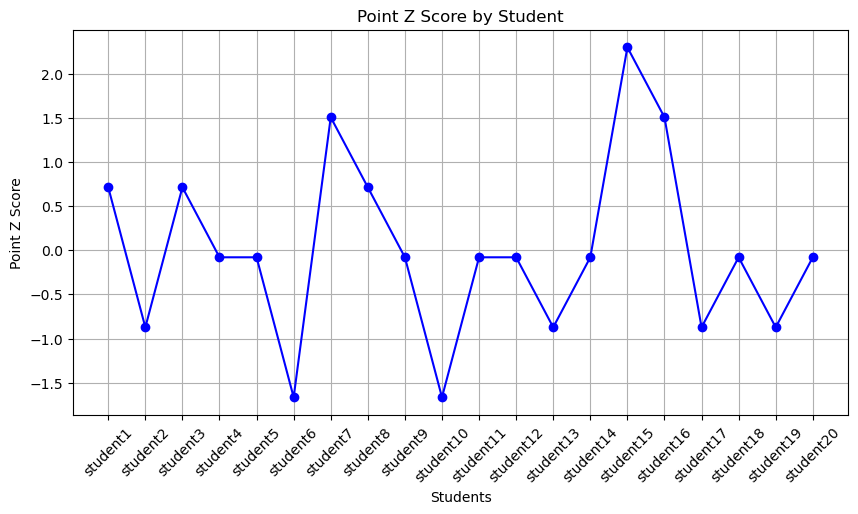

In [16]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN1']
scores = [point_z_score(point_df, item, student) for student in students]

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, marker='o', linestyle='-', color='b', label="Point Z Score")
plt.xlabel("Students")
plt.ylabel("Point Z Score")
plt.title("Point Z Score by Student")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 상대적인 위치라서 학생들의 값의 절대적 차이에 비해 드라마틱하게 나타남
# 그러나 범위가 고정되어 있지 않기때문에 y축이 동적임
# 현장 데이터가 어떠한지 모르겠으나 0 지명인 아동이 많다면 평균은 0에 가까울 것
# 0이 대부분이고 양적인 변화만 있는 데이터일텐데.... 어떤 점수 산출이 효과적일지...?

또래지명 결과 산출
* Z점수 활용해 5가지 수준 산출 및 넘버링

백분위|Z-score 범위|넘버링|수준|
|------|---|---|---|
|상위 20% (80-100%)|+0.84<=Z|5|매우 높음|
|60-80%|+0.25<=Z<+0.84|4|높음|
|40-60%|-0.25<=Z<+0.25|3|보통|
|20-40%|-0.84<=Z<-0.25|2|낮음|
|하위 20% (0-20%)|Z<-0.84|1|매우 낮음|

In [19]:
# 또래지명 Z 점수에 따른 수준 분류 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# Z점수의 백분위에 따라 5가지 분류
# 일반적으로 Z 점수에 따른 백분위 분류방법으로 산출
import numpy as np
from scipy.stats import zscore

def covert_z_level(z_score_list) :
    level_list = np.where(z_score_list >= 0.84, 5,
                          np.where(z_score_list >= 0.25, 4,
                                   np.where(z_score_list >= -0.25, 3,
                                            np.where(z_score_list >= -0.84, 2,1))))
    return level_list

def point_z_level_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
        z_score_list = zscore(temp_list)
        level_list = covert_z_level(z_score_list)
        level = level_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return level

In [21]:
item = ['PN1']
point_z_level_score(point_df, item, 'student20')

3

[3, 3, 3, 1, 2, 2, 3, 2, 3, 3, 2, 4, 3, 1, 5, 1, 3, 5, 2, 5]


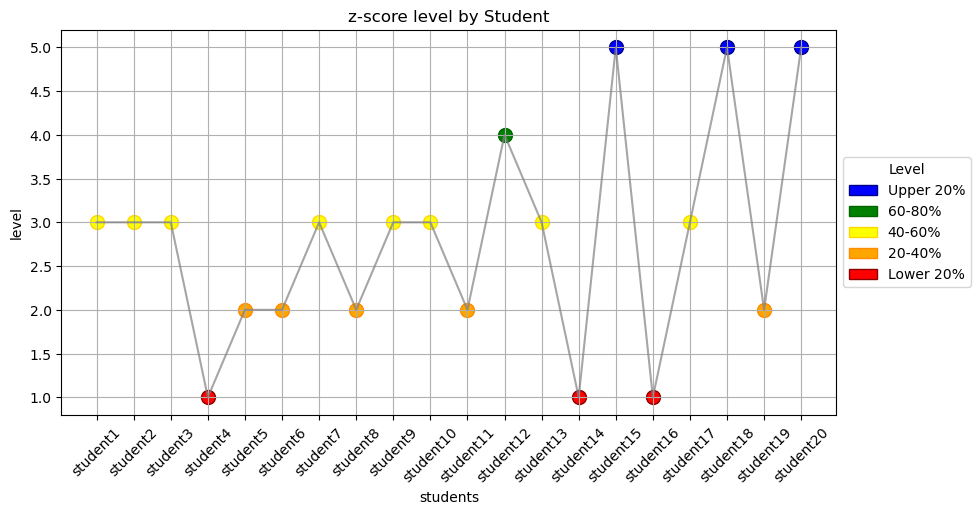

In [39]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN12','PN13']
scores = [point_z_level_score(point_df, item, student) for student in students]
print(scores)

# 점수에 따른 색상 맵핑
inner_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
border_colors = {1: 'darkred', 2: 'darkorange', 3: 'gold', 4: 'darkgreen', 5: 'darkblue'}

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, linestyle='-', color='gray', alpha=0.7, label="z-score level Score")

# 점 개별 색상 적용
for i, student in enumerate(students):
    plt.scatter(student, scores[i], s=100,
                facecolors=inner_colors[scores[i]],
                edgecolors=border_colors[scores[i]],
                linewidth=1, marker='o')

plt.xlabel("students")
plt.ylabel("level")
plt.title("z-score level by Student")
plt.xticks(rotation=45)
plt.grid(True)

# 수동 범례 추가
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='blue', edgecolor='darkblue', label="Upper 20%"),
    Patch(facecolor='green', edgecolor='darkgreen', label="60-80%"),
    Patch(facecolor='yellow', edgecolor='gold', label="40-60%"),
    Patch(facecolor='orange', edgecolor='darkorange', label="20-40%"),
    Patch(facecolor='red', edgecolor='darkred', label="Lower 20%")
]

plt.legend(handles=legend_elements, loc="center left", title="Level", bbox_to_anchor=(1, 0.5))

plt.show()

# y축 범위가 1에서 5점이기 때문에 정적
# 드라마틱하게 산출

또래지명 결과 산출
* 집단 내 백분위로 점수 산출

In [85]:
# 집단 내 백분위로 점수 산출
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
import numpy as np
from scipy.stats import rankdata

def per_value(values):
    ranks = rankdata(values, method="average")
    per_list = (ranks - 1) / (len(values) - 1) * 100
    return per_list

def point_per_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
            temp_arr = np.array(temp_list)
        per_list = np.round(per_value(temp_arr), 2)
        per = per_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return per

In [86]:
item = ['PN1']
point_per_score(point_df, item, 'student16')

100.0

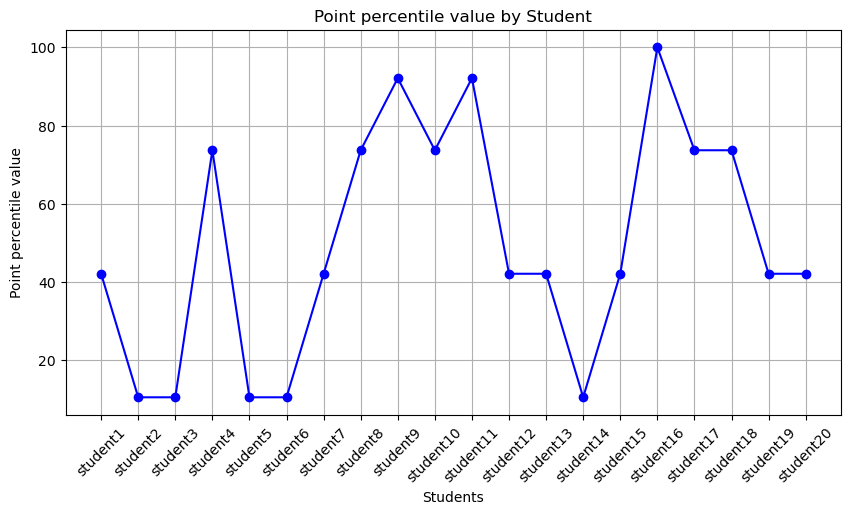

In [87]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN1']
scores = [point_per_score(point_df, item, student) for student in students]

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, marker='o', linestyle='-', color='b', label="Point percentile value")
plt.xlabel("Students")
plt.ylabel("Point percentile value")
plt.title("Point percentile value by Student")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

또래지명 결과 산출
* 집단 내 백분위로 5 수준으로 구분하여 산출

백분위 범위|넘버링|수준|
|----------|------|----|
|상위 20% (80-100%)|5|매우 높음|
|60-80%|4|높음|
|40-60%|3|보통|
|20-40%|2|낮음|
|하위 20% (0-20%)|1|매우 낮음|

In [89]:
# 집단내 백분위에 따른 수준 분류 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 백분위에 따라 5가지 분류
# 일반적으로 수준별 20%씩 분류하여 산출
import numpy as np
from scipy.stats import rankdata

def covert_p_level(per_list) :
    level_list = np.where(per_list >= 80, 5,
                          np.where(per_list >= 60, 4,
                                   np.where(per_list >= 40, 3,
                                            np.where(per_list >= 20, 2,1))))
    return level_list

def per_value(values):
    ranks = rankdata(values, method="average")
    per_list = (ranks - 1) / (len(values) - 1) * 100
    return per_list

def point_per_level_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.fullmatch(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
            temp_arr = np.array(temp_list)
        per_list = np.round(per_value(temp_arr), 2)
        level_list = covert_p_level(per_list)
        level = level_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return level

In [90]:
item = ['PN1']
point_per_level_score(point_df, item, 'student16')

5

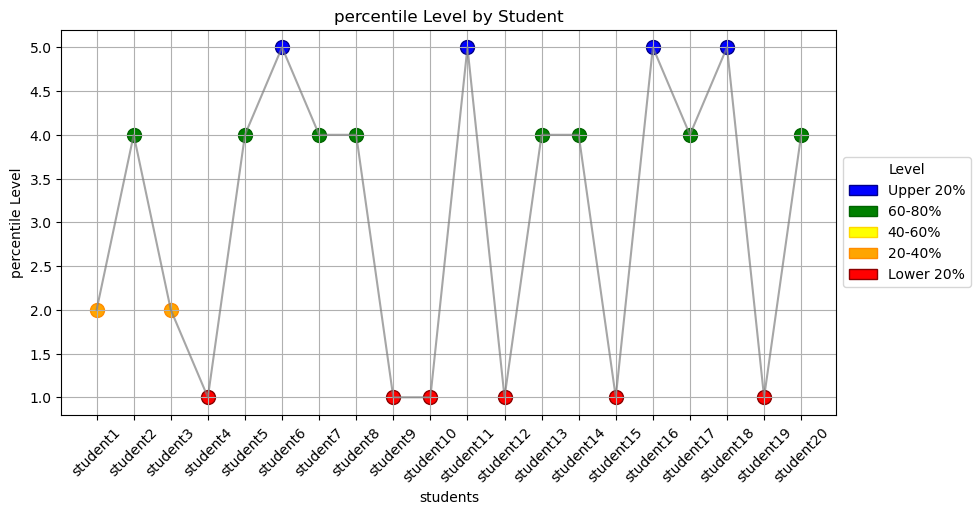

In [91]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN8', 'PN9']
scores = [point_per_level_score(point_df, item, student) for student in students]

# 점수에 따른 색상 맵핑
inner_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
border_colors = {1: 'darkred', 2: 'darkorange', 3: 'gold', 4: 'darkgreen', 5: 'darkblue'}

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, linestyle='-', color='gray', alpha=0.7, label="percentile Level Score")

# 점 개별 색상 적용
for i, student in enumerate(students):
    plt.scatter(student, scores[i], s=100,
                facecolors=inner_colors[scores[i]],
                edgecolors=border_colors[scores[i]],
                linewidth=1, marker='o')

plt.xlabel("students")
plt.ylabel("percentile Level")
plt.title("percentile Level by Student")
plt.xticks(rotation=45)
plt.grid(True)

# 수동 범례 추가
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='blue', edgecolor='darkblue', label="Upper 20%"),
    Patch(facecolor='green', edgecolor='darkgreen', label="60-80%"),
    Patch(facecolor='yellow', edgecolor='gold', label="40-60%"),
    Patch(facecolor='orange', edgecolor='darkorange', label="20-40%"),
    Patch(facecolor='red', edgecolor='darkred', label="Lower 20%")
]

plt.legend(handles=legend_elements, loc="center left", title="Level", bbox_to_anchor=(1, 0.5))

plt.show()

# z 점수와 집단 내 백분위를 가지고 수준산출해서 나온 경우 비교.


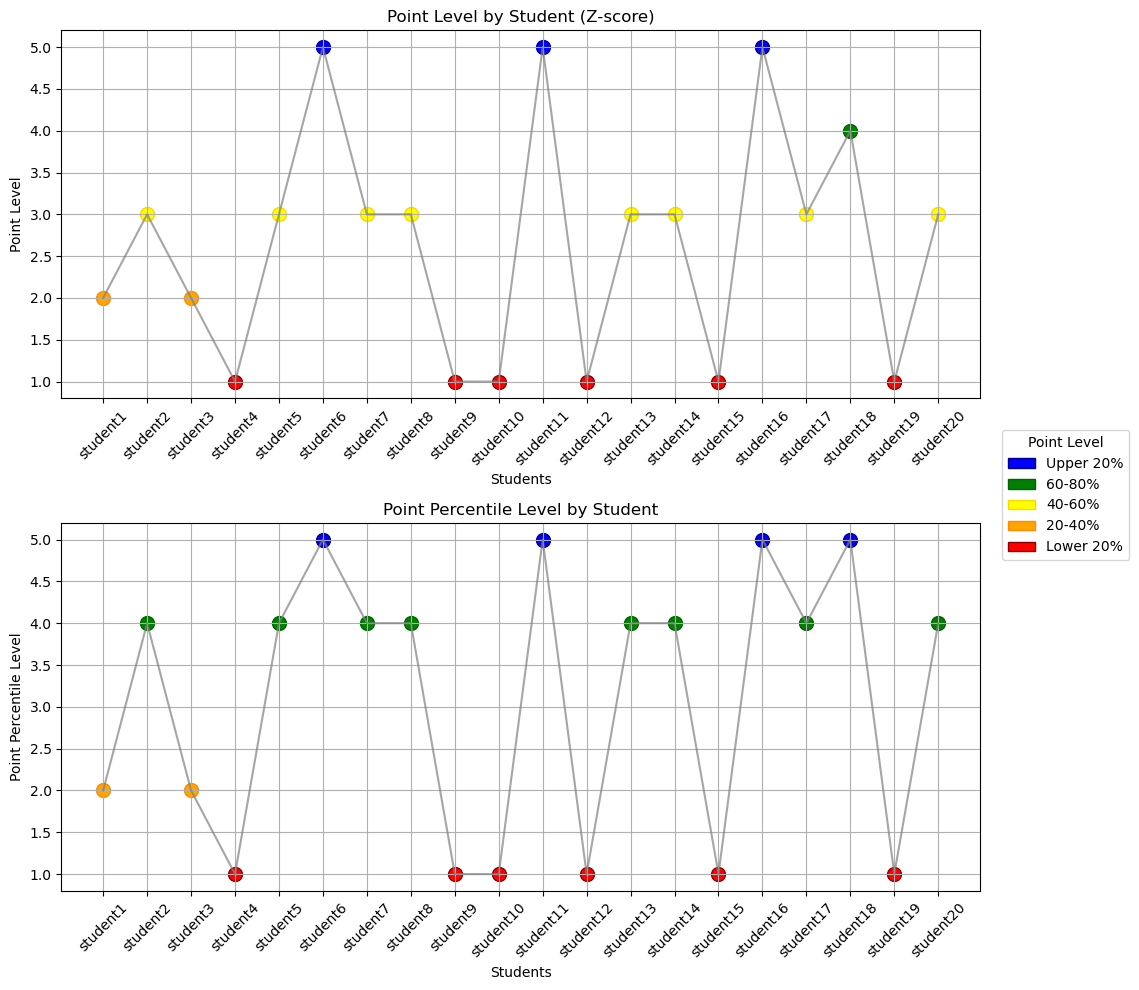

In [96]:
students = point_df['student_designation'].unique().tolist()
#item = ['PN1']
#item = ['PN2', 'PN3']
#item = ['PN4', 'PN5']
#item = ['PN6', 'PN7']
item = ['PN8', 'PN9']
scores_z = [point_z_level_score(point_df, item, student) for student in students]
scores_per = [point_per_level_score(point_df, item, student) for student in students]

# 점수에 따른 색상 맵핑
inner_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
border_colors = {1: 'darkred', 2: 'darkorange', 3: 'gold', 4: 'darkgreen', 5: 'darkblue'}

# 서브플롯 생성
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# 첫 번째 그래프 z score 기반
axes[0].plot(students, scores_z, linestyle='-', color='gray', alpha=0.7, label="Point Level Score")
for i, student in enumerate(students):
    axes[0].scatter(student, scores_z[i], s=100,
                    facecolors=inner_colors[scores_z[i]],
                    edgecolors=border_colors[scores_z[i]],
                    linewidth=1, marker='o')
axes[0].set_xlabel("Students")
axes[0].set_ylabel("Point Level")
axes[0].set_title("Point Level by Student (Z-score)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# 두 번째 그래프 per score 기반
axes[1].plot(students, scores_per, linestyle='-', color='gray', alpha=0.7, label="Point Level Score")
for i, student in enumerate(students):
    axes[1].scatter(student, scores_per[i], s=100,
                    facecolors=inner_colors[scores_per[i]],
                    edgecolors=border_colors[scores_per[i]],
                    linewidth=1, marker='o')
axes[1].set_xlabel("Students")
axes[1].set_ylabel("Point Percentile Level")
axes[1].set_title("Point Percentile Level by Student")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

# 수동 범례 추가
legend_elements = [
    Patch(facecolor='blue', edgecolor='darkblue', label="Upper 20%"),
    Patch(facecolor='green', edgecolor='darkgreen', label="60-80%"),
    Patch(facecolor='yellow', edgecolor='gold', label="40-60%"),
    Patch(facecolor='orange', edgecolor='darkorange', label="20-40%"),
    Patch(facecolor='red', edgecolor='darkred', label="Lower 20%")
]

# 범례를 그래프 바깥에 배치
fig.legend(handles=legend_elements, loc="center left", title="Point Level", bbox_to_anchor=(1, 0.5))

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

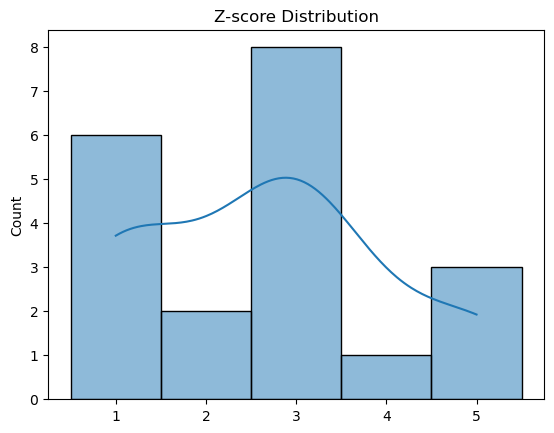

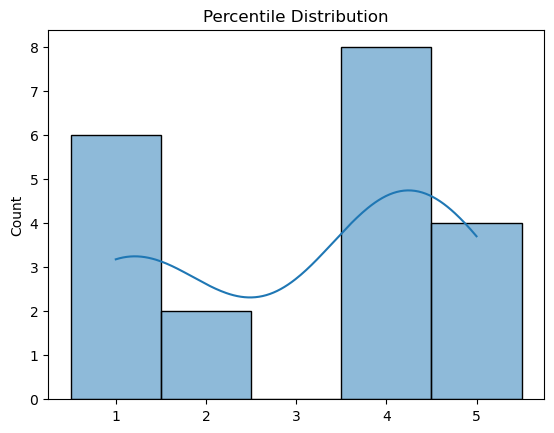

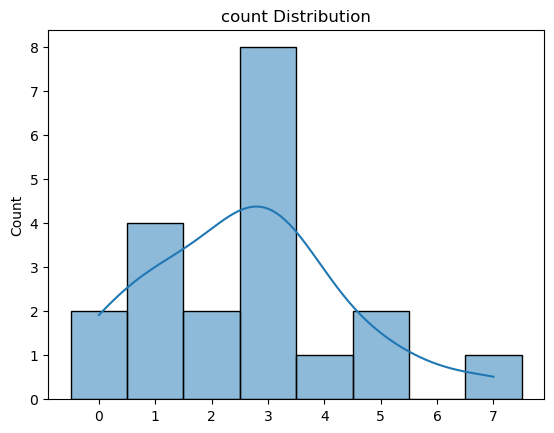

In [97]:
import seaborn as sns

sns.histplot(scores_z, kde=True, bins=5, discrete=True)
plt.title("Z-score Distribution")
plt.show()

sns.histplot(scores_per, kde=True, bins=5, discrete=True)
plt.title("Percentile Distribution")
plt.show()

count = [count_score(point_df, item, student) for student in students]
sns.histplot(count, kde=True, bins=5, discrete=True)
plt.title("count Distribution")
plt.show()

In [98]:
print(count)
print(scores_z)
print(scores_per)

[2, 3, 2, 1, 3, 5, 3, 3, 1, 1, 7, 0, 3, 3, 0, 5, 3, 4, 1, 3]
[2, 3, 2, 1, 3, 5, 3, 3, 1, 1, 5, 1, 3, 3, 1, 5, 3, 4, 1, 3]
[2, 4, 2, 1, 4, 5, 4, 4, 1, 1, 5, 1, 4, 4, 1, 5, 4, 5, 1, 4]


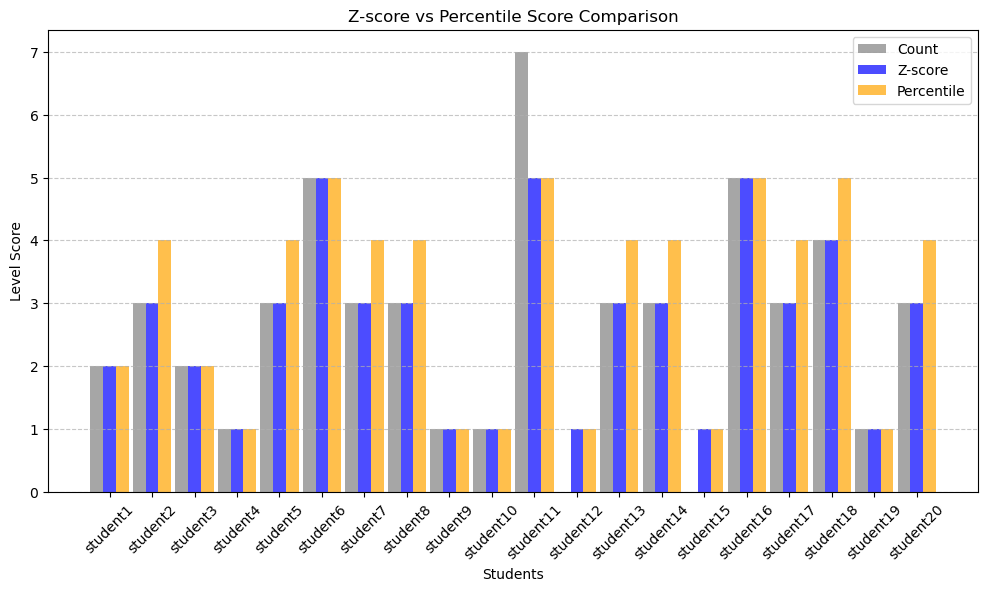

In [99]:
# 학생 목록 생성
students = [f"student{i+1}" for i in range(len(count))]

# 데이터프레임 생성
df = pd.DataFrame({'Student': students, 'Count': count, 'Z-score': scores_z, 'Percentile': scores_per})

bar_width = 0.3  # 막대 너비 설정
index = np.arange(len(students))  # X축 인덱스

# 막대그래프 생성 (Z-score vs Percentile 비교)
fig, ax = plt.subplots(figsize=(12, 6))

# Count 막대 (회색)
bars3 = ax.bar(index - bar_width, df['Count'], bar_width, label="Count", color='gray', alpha=0.7)

# Z-score 막대
bars1 = ax.bar(index, df['Z-score'], bar_width, label="Z-score", color='blue', alpha=0.7)

# Percentile 막대
bars2 = ax.bar(index + bar_width, df['Percentile'], bar_width, label="Percentile", color='orange', alpha=0.7)

# X축 설정
ax.set_xlabel("Students")
ax.set_ylabel("Level Score")
ax.set_title("Z-score vs Percentile Score Comparison")
ax.set_xticks(index)
ax.set_xticklabels(students, rotation=45)
ax.legend()

# 그래프 출력
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

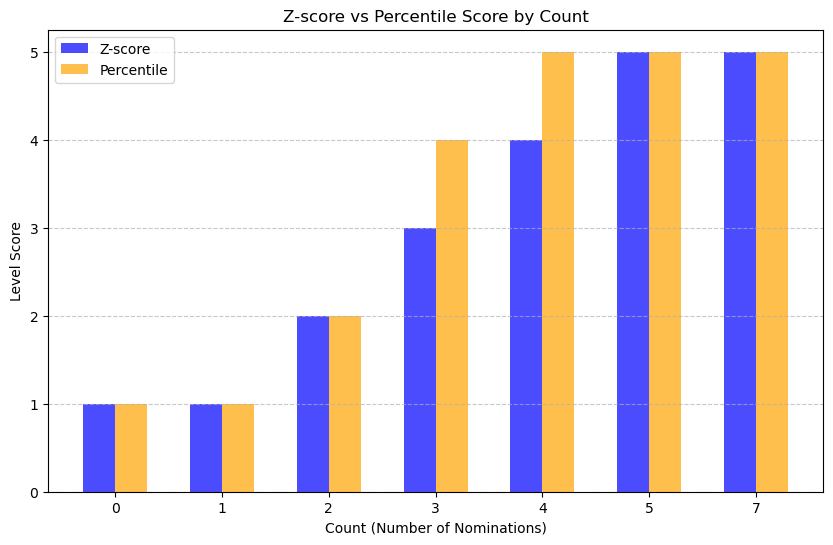

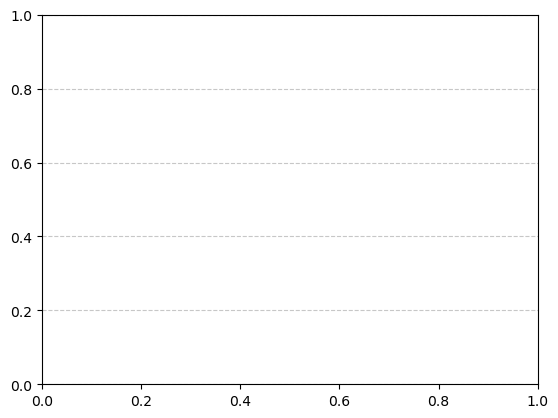

In [100]:
# 데이터프레임을 Count 기준으로 그룹화하여 평균 Z-score 및 Percentile Score 계산
df_grouped = df.groupby('Count')[['Z-score', 'Percentile']].mean().reset_index()

# 막대그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.3  # 막대 너비 설정
index = np.arange(len(df_grouped['Count']))  # X축 인덱스

# Z-score 막대 (파란색)
bars1 = ax.bar(index - bar_width/2, df_grouped['Z-score'], bar_width, label="Z-score", color='blue', alpha=0.7)

# Percentile Score 막대 (주황색)
bars2 = ax.bar(index + bar_width/2, df_grouped['Percentile'], bar_width, label="Percentile", color='orange', alpha=0.7)

# X축 설정
ax.set_xlabel("Count (Number of Nominations)")
ax.set_ylabel("Level Score")
ax.set_title("Z-score vs Percentile Score by Count")
ax.set_xticks(index)
ax.set_xticklabels(df_grouped['Count'])
ax.legend()

# 그래프 출력
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# count 3 값의 빈도가 커지기 때문에 이x.set_xticklabels(df_grouped['Count'])
ax.legend()

# 그래프 출력
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# count 3 값의 빈도가 커지기 때문에 이

In [102]:
df_grouped

,Count,Z-score,Percentile
0,0,1.0,1.0
1,1,1.0,1.0
2,2,2.0,2.0
3,3,3.0,4.0
4,4,4.0,5.0
5,5,5.0,5.0
6,7,5.0,5.0


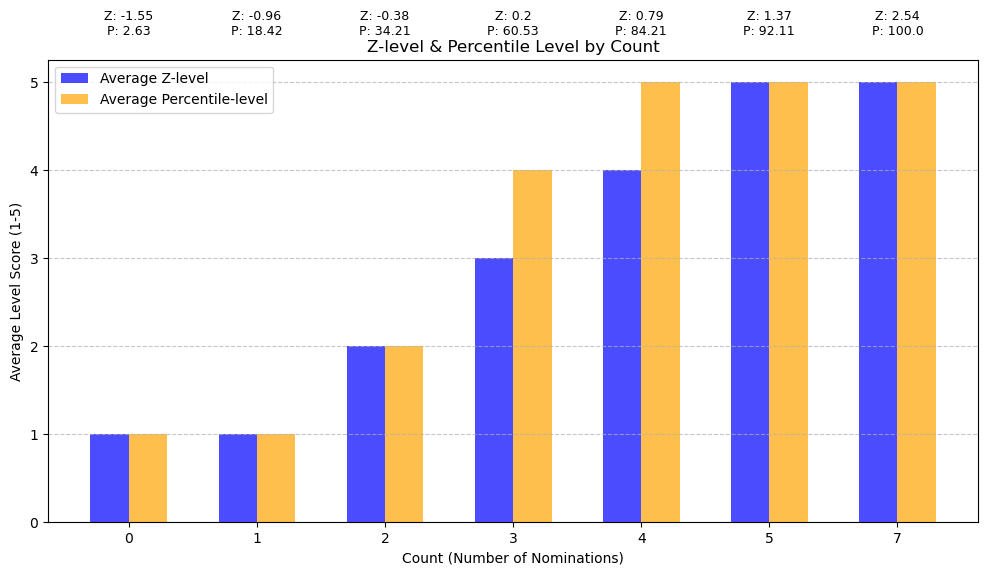

In [105]:
# 학생 목록 가져오기
students = point_df['student_designation'].unique().tolist()
item = ['PN8', 'PN9']

# Count 값 계산
count_values = [count_score(point_df, item, student) for student in students]

# Z-score 및 Percentile Score 계산
z_scores = [point_z_score(point_df, item, student) for student in students]
percentiles = [point_per_score(point_df, item, student) for student in students]

# 수준(Level) 계산
scores_z = [point_z_level_score(point_df, item, student) for student in students]
scores_per = [point_per_level_score(point_df, item, student) for student in students]

# 데이터프레임 생성
df_scores = pd.DataFrame({
    'Student': students,
    'Count': count_values,
    'Z-score': z_scores,
    'Percentile': percentiles,
    'Z-level': scores_z,
    'Percentile-level': scores_per
})

# Count 값별 그룹화하여 Z-score 및 Percentile Score의 고유값만 남김
df_grouped_unique = df_scores.groupby('Count').agg(
    Z_scores=('Z-score', lambda x: ', '.join(map(str, sorted(set(np.round(x, 2)))))),
    Percentiles=('Percentile', lambda x: ', '.join(map(str, sorted(set(np.round(x, 2)))))),
    Z_levels=('Z-level', lambda x: ', '.join(map(str, sorted(set(x))))),
    Percentile_levels=('Percentile-level', lambda x: ', '.join(map(str, sorted(set(x)))))
).reset_index()

# 막대그래프 생성 (Count별 Z-score 수준 및 Percentile 수준 비교)
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.3  # 막대 너비 설정
index = np.arange(len(df_grouped_unique['Count']))  # X축 인덱스

# Z-score 평균 수준 막대 (파란색)
bars1 = ax.bar(index - bar_width/2, df_scores.groupby('Count')['Z-level'].mean(),
               bar_width, label="Average Z-level", color='blue', alpha=0.7)

# Percentile 평균 수준 막대 (주황색)
bars2 = ax.bar(index + bar_width/2, df_scores.groupby('Count')['Percentile-level'].mean(),
               bar_width, label="Average Percentile-level", color='orange', alpha=0.7)

# X축 설정 (고유한 Count 값 표시)
ax.set_xlabel("Count (Number of Nominations)")
ax.set_ylabel("Average Level Score (1-5)")
ax.set_title("Z-level & Percentile Level by Count")
ax.set_xticks(index)
ax.set_xticklabels(df_grouped['Count'])
ax.legend()

# 각 Count 값 위에 Z-score 및 Percentile Score 표기 (레벨 제거)
for i, (count, z_vals, per_vals) in enumerate(zip(
    df_grouped_unique['Count'], df_grouped_unique['Z_scores'], df_grouped_unique['Percentiles']
)):
    text = f"Z: {z_vals}\nP: {per_vals}"  # 수준 값 (Z_Lv, P_Lv) 제거
    ax.text(i, max(df_scores['Z-level'].max(), df_scores['Percentile-level'].max()) + 0.5,
            text, ha='center', va='bottom', fontsize=9, color='black')

# 그래프 출력
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [106]:
df_grouped

,Count,Z-score,Percentile
0,0,1.0,1.0
1,1,1.0,1.0
2,2,2.0,2.0
3,3,3.0,4.0
4,4,4.0,5.0
5,5,5.0,5.0
6,7,5.0,5.0


In [107]:
# 학생 목록 가져오기
students = point_df['student_designation'].unique().tolist()
item = ['PN8', 'PN9']

# Count 값 계산
count_values = [count_score(point_df, item, student) for student in students]

# Z-score 및 Percentile Score 계산
z_scores = [point_z_score(point_df, item, student) for student in students]
percentiles = [point_per_score(point_df, item, student) for student in students]

# 수준(Level) 계산
scores_z = [point_z_level_score(point_df, item, student) for student in students]
scores_per = [point_per_level_score(point_df, item, student) for student in students]

# 데이터프레임 생성
df_scores = pd.DataFrame({
    'Student': students,
    'Count': count_values,
    'Z-score': z_scores,
    'Percentile': percentiles,
    'Z-level': scores_z,
    'Percentile-level': scores_per
})

# Count 값별 그룹화하여 Z-score 및 Percentile Score의 고유값만 남김
df_grouped_unique = df_scores.groupby('Count').agg(
    Z_scores=('Z-score', lambda x: ', '.join(map(str, sorted(set(np.round(x, 2)))))),
    Percentiles=('Percentile', lambda x: ', '.join(map(str, sorted(set(np.round(x, 2)))))),
    Z_levels=('Z-level', lambda x: ', '.join(map(str, sorted(set(x))))),
    Percentile_levels=('Percentile-level', lambda x: ', '.join(map(str, sorted(set(x)))))
).reset_index()

In [108]:
df_grouped_unique

,Count,Z_scores,Percentiles,Z_levels,Percentile_levels
0,0,-1.55,2.63,1,1
1,1,-0.96,18.42,1,1
2,2,-0.38,34.21,2,2
3,3,0.2,60.53,3,4
4,4,0.79,84.21,4,5
5,5,1.37,92.11,5,5
6,7,2.54,100.0,5,5


ex)  
동점의 순위를 평균 순위로 처리하면   
-> 같은 점수의 수가 많은 특정 점수부터 백분위가 급격하게 증가함  
동점의 순위를 최소 순위로 처리하면  
-> 같은 점수의 수가 많은 지점에서 그 뒤로 갈때 백분위 간격이 넓어짐  

### 또래지명을 통한 학생의 평가와 교사의 학생 평가의 일치율을 구하는 방법 탐색  

* 피어슨 상관계수
* 스피어만 상관계수
* 유클리드 거리
* 단순 일치율

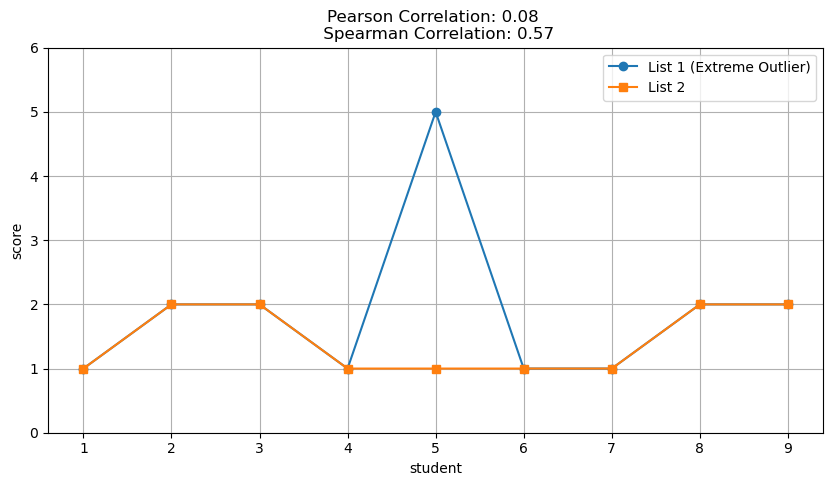

0.08304547985374
0.5692099788303083


In [121]:
# 피어슨 상관계수
# 증사 및 감소 패턴의 유사도를 확인할 수 있음
# 평균 기반으로 계산되기 때문에 극단치가 있는 경우 왜곡될 수 있음.
import numpy as np
import scipy.stats as stats

# 완벽일치+하나의 극단 케이스
list_1 = [1,2,2,1,5,1,1,2,2]
list_2 = [1,2,2,1,1,1,1,2,2]
'''
# 일부일치+하나의 극단 케이스
list_1 = [1,2,2,1,1,1,1,2,2]
list_2 = [1,2,1,2,5,2,1,1,2]
# 평행하게 일치하는 경우
list_1 = [1,2,2,1,3,1,1,2,2]
list_2 = [3,4,2,3,5,3,3,4,4]
'''

# 상관계수 계산 (피어슨 상관계수)
pearson_corr, _ = stats.pearsonr(list_1, list_2)

# 스피어만 상관계수 계산 (순위 기반 상관계수)
spearman_corr, _ = stats.spearmanr(list_1, list_2)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), list_1, marker='o', linestyle='-', label='List 1 (Extreme Outlier)')
plt.plot(range(1, 10), list_2, marker='s', linestyle='-', label='List 2')

plt.xlabel("student")
plt.ylim(0, 6)
plt.ylabel("score")
plt.title(f"Pearson Correlation: {pearson_corr:.2f} \n Spearman Correlation: {spearman_corr:.2f}")
plt.legend()
plt.grid(True)

plt.show()

# 상관계수 출력
print(pearson_corr)
# 결과 출력
print(spearman_corr)

In [123]:
# 유클리드 거리 계산
euclidean_distance = np.sqrt(np.sum((np.array(list_1) - np.array(list_2))**2))

# 최대 유클리드 거리 계산 (최악의 경우: 한 리스트가 1, 다른 리스트가 5)
max_euclidean_distance = np.sqrt(len(list_1) * (5 - 1) ** 2)

# 유클리드 거리 기반 일치율 변환
euclidean_agreement = (1 - (euclidean_distance / max_euclidean_distance)) * 100
euclidean_agreement = max(0, euclidean_agreement)  # 음수가 나오지 않도록 보정

# 결과 출력
print(f"유클리드 거리 기반 일치율: {euclidean_agreement:.2f}%")

유클리드 거리 기반 일치율: 66.67%


In [125]:
# 단순 일치율(Simple Matching Ratio, SMR) 계산

# 일치하는 값의 개수 계산
matching_count = sum(1 for x, y in zip(list_1, list_2) if x == y)

# 전체 데이터 개수
total_count = len(list_1)

# 단순 일치율 계산 (일치하는 개수 / 전체 개수 * 100)
simple_matching_ratio = (matching_count / total_count) * 100

# 결과 출력
simple_matching_ratio

88.88888888888889

In [127]:
# 방법 1: 절대값 변환 방식
pearson_agreement_abs = abs(pearson_corr) * 100
spearman_agreement_abs = abs(spearman_corr) * 100

# 방법 2: 음수 제거 방식 (0 이하이면 0%로 처리)
pearson_agreement_no_neg = max(0, pearson_corr * 100)
spearman_agreement_no_neg = max(0, spearman_corr * 100)

# 결과 출력
print(f"피어슨 상관계수 기반 일치율 (절대값 변환): {pearson_agreement_abs:.2f}%")
print(f"피어슨 상관계수 기반 일치율 (음수 제거): {pearson_agreement_no_neg:.2f}%")
print(f"스피어만 상관계수 기반 일치율 (절대값 변환): {spearman_agreement_abs:.2f}%")
print(f"스피어만 상관계수 기반 일치율 (음수 제거): {spearman_agreement_no_neg:.2f}%")

피어슨 상관계수 기반 일치율 (절대값 변환): 8.30%
피어슨 상관계수 기반 일치율 (음수 제거): 8.30%
스피어만 상관계수 기반 일치율 (절대값 변환): 56.92%
스피어만 상관계수 기반 일치율 (음수 제거): 56.92%
